<a href="https://colab.research.google.com/github/MarcosVeniciu/Xception_CNN_Dogs_vs_Cats/blob/main/Xception_CNN_Dogs_vs_Cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuração do DataSet [1][2]

In [1]:
# Intalação do keggle

! pip install -q kaggle

## Configurando acesso a API 

importar o arquivo keggle.json que foi baixado com as informações da API. 


In [ ]:
# Lê o arquivo Kaggle.json

from google.colab import files
files.upload()

In [3]:
# Cria uma pasta chamada Keggle e copia o arquivo Json para ela.
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

# Altera as permisções para o arquivo keggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Verifica uma lista de dataset do keggle. Se a lista for exibida, esntão ta tudo certo. (opcional)
! kaggle datasets list

## Donwload do DataSet



In [4]:
# Download do DataSet.[3]
# É preciso aceitar as regras na aba de Rules na pagina do dataset[4], para poder fazer o download do dataset

! kaggle competitions download -c dogs-vs-cats

 99% 808M/812M [00:04<00:00, 220MB/s]
100% 812M/812M [00:04<00:00, 200MB/s]


In [5]:
# Cria uma pasta chamada Dog_Cat
! mkdir Dog_Cat

In [6]:
# Descompacta o arquivo dog-vs-cats na pasta Dog_Cat

! unzip dogs-vs-cats.zip -d Dog_Cat

Archive:  dogs-vs-cats.zip
  inflating: Dog_Cat/sampleSubmission.csv  
  inflating: Dog_Cat/test1.zip       
  inflating: Dog_Cat/train.zip       


O arquivo dogs-vs-cats.zip tem dois outros arquivos zip. \
train.zip que é a pasta onde estão as imagens para o treino e para a validação. \
test1.zip é onde estão as imagens que não são usadas para realizar os testes.

In [ ]:
# Descompacta as imagens para o teste da rede, que estão no arquivo test1.zip para a pasta Dog_Cat

! unzip Dog_Cat/test1.zip -d Dog_Cat

In [ ]:
# Descompacta as imagens de treino e validação que estão no arquivo train.zip para a pasta Dog_Cat
! unzip Dog_Cat/train.zip -d Dog_Cat

In [9]:
# renomeia as pastas
# os.rename('/pasta/subpasta/nome_atual', /pasta/subpasta/novo_nome')

import os

os.rename('/content/Dog_Cat/train', '/content/Dog_Cat/dataset') # renomeia a pasta train para dataset_treino
os.rename('/content/Dog_Cat/test1', '/content/Dog_Cat/dataset_teste')  # renomeia a pasta test1 para dataset_teste

In [10]:
# Cria as pastas onde as imagens serão salvas
# e cria as subpastas para as calsses dogs e cats, nas pastas de treino e validação
 
! mkdir Dog_Cat/dataset_teste_local # para as imagens de teste que estão no meu pc 

! mkdir Dog_Cat/dataset/dogs 
! mkdir Dog_Cat/dataset/cats

! mkdir Dog_Cat/dataset_teste_local/dogs
! mkdir Dog_Cat/dataset_teste_local/cats

In [11]:
# Move as imagens de gatos para a pasta cats e as imagens de cachorros para a pasta dogs.
import os
import shutil


# Mover os gatos 
for i in range(12500):
  caminho_origem =  "/content/Dog_Cat/dataset/cat." + str(i) + ".jpg"
  caminho_destino = "/content/Dog_Cat/dataset/cats/cat." + str(i) + ".jpg"
  shutil.move(caminho_origem, caminho_destino)

# Mover os Cãos
for i in range(12500):
  caminho_origem =  "/content/Dog_Cat/dataset/dog." + str(i) + ".jpg"
  caminho_destino = "/content/Dog_Cat/dataset/dogs/dog." + str(i) + ".jpg"
  shutil.move(caminho_origem, caminho_destino)

In [12]:
# Contar o numero de imagens nas pastas
# Treino
!echo DataSet Cats
!ls Dog_Cat/dataset/cats/*.jpg | wc | awk '{print $1}' 
!echo DataSet Dogs
!ls Dog_Cat/dataset/dogs/*.jpg | wc | awk '{print $1}'


# Testes
!echo Testes Dogs e Cats
!ls Dog_Cat/dataset_teste/*.jpg | wc | awk '{print $1}'


DataSet Cats
12500
DataSet Dogs
12500
Testes Dogs e Cats
12500


#  Xception network [5] [6]

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Pré-processamento das imagens de treino e validação

In [14]:
image_size = (180, 180)
batch_size = 32

In [15]:


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Dog_Cat/dataset",
    validation_split=0.2, # proporção das imagens que estão na pasta e vao ser usados para o treinamento
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Dog_Cat/dataset",
    validation_split=0.2, # proporção das imagens que estão na pasta e vao ser usados para a validação
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [16]:
# Verifica o nome da classe (diretorio das imagens) e o indice dela
print(train_ds.class_names)
print(val_ds.class_names)

['cats', 'dogs']
['cats', 'dogs']


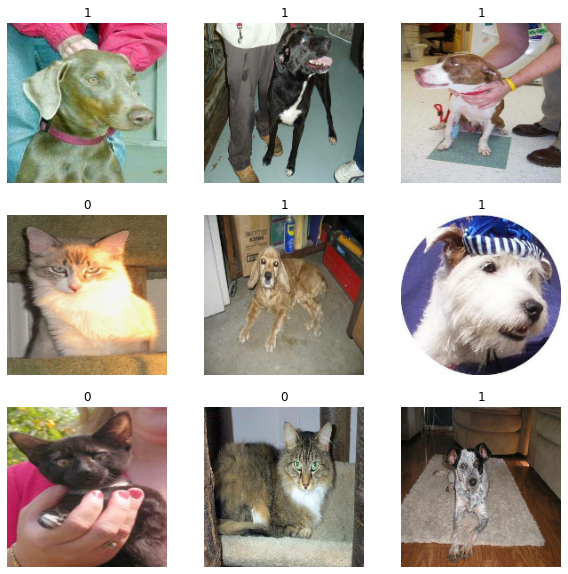

In [17]:
# Visualizar algumas das imagens. Onde o numero acima da imagen indica o indice da classe. 1 para cães e 0 para gatos.

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [18]:
# Aplicando algumas transformações nas imagens, para aumentar o dataset

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

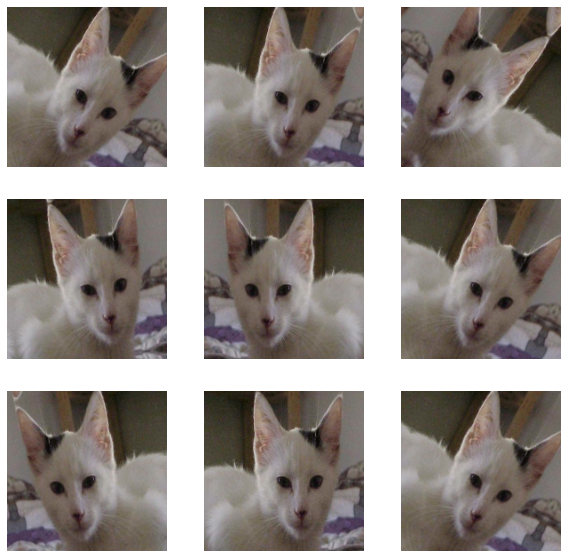

In [19]:
# Exibir alguns exemplos de transformações

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [20]:
# Configurando o dataset
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## Construindo o Modelo

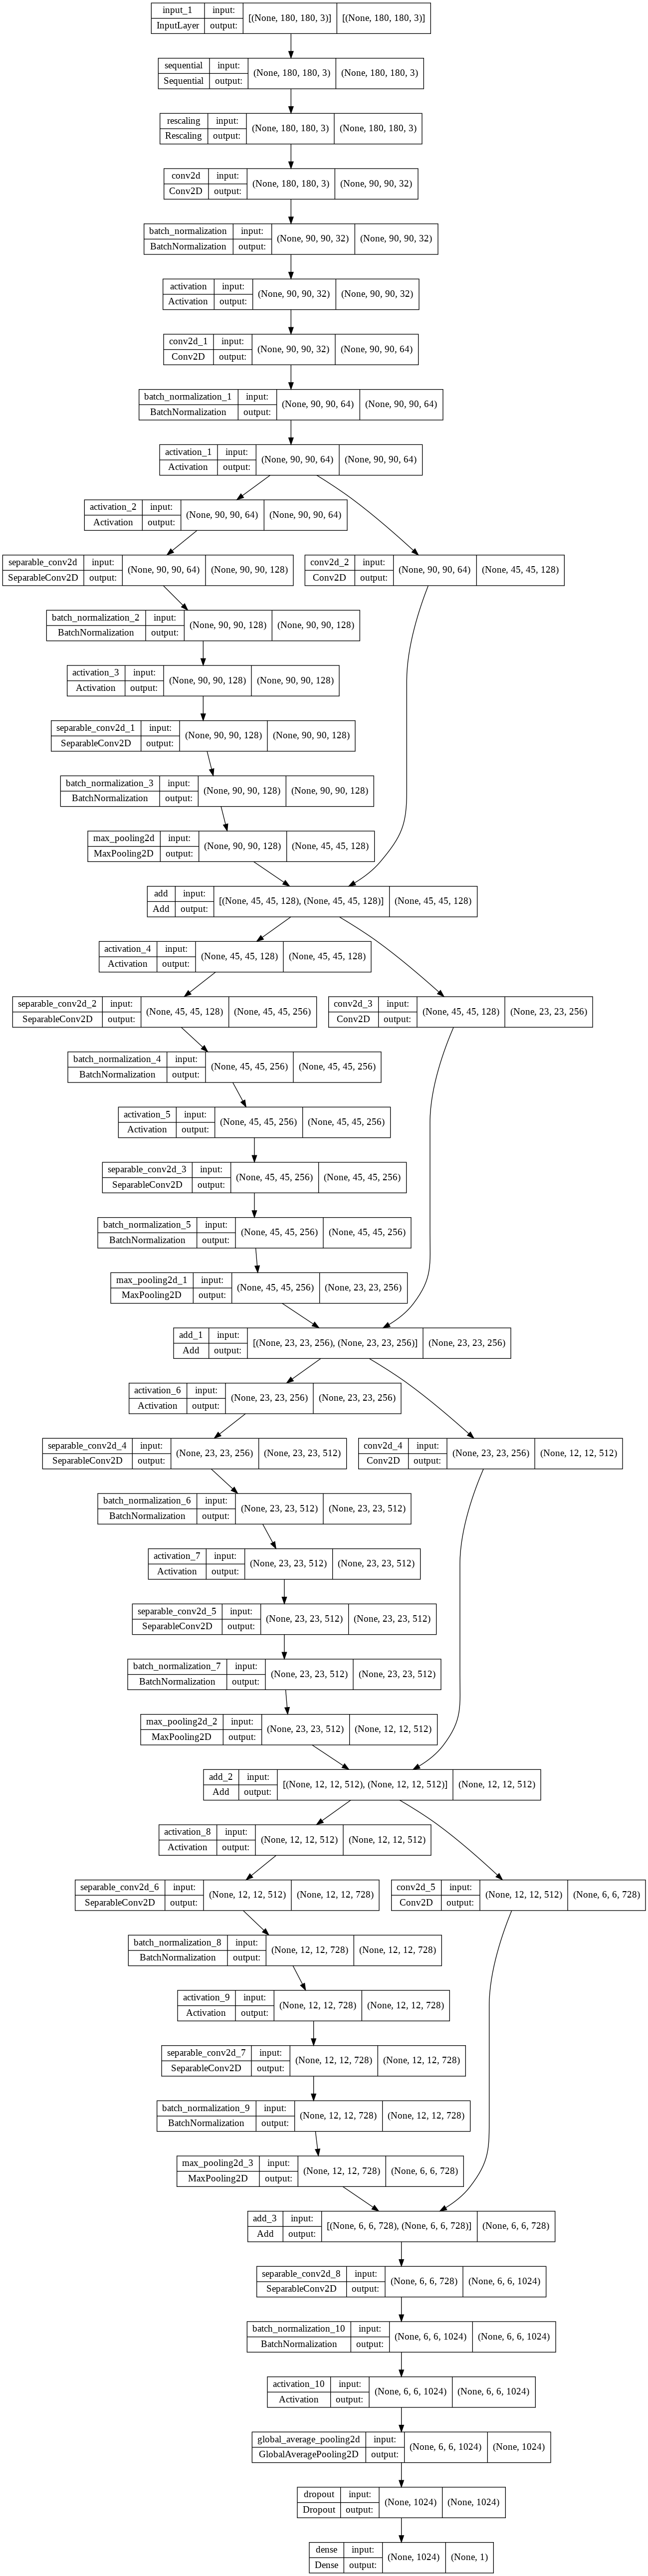

In [21]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 180, 180, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 180, 180, 3)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 90, 90, 32)   896         ['rescaling[0][0]']          

## Treinando o Modelo

Posso caregar os pesos salvo para continuar treinando a partir deses pesos ou ir direto para a previsão.

In [ ]:
# Fazendo o upload do arquivo com os pesos pre-treinado
from google.colab import files
files.upload()

Saving Xception_save_at_50.h5 to Xception_save_at_50.h5


In [ ]:
# Carregando os pesos no modelo
Local = "/content/Xception_save_at_50.h5"
model.load_weights(Local)

Continuar com o treinamento ou começar um novo treinamento.

In [ ]:
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint("Xception_save_at_{epoch}.h5"), # Salva os pessos
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
historico = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

In [ ]:
# Cruva de aprendizado [7]
from matplotlib import pyplot

pyplot.title('Curva de Aprendizado')
pyplot.xlabel('Epoch')
pyplot.ylabel('Cross Entropy')
pyplot.plot(historico.history['loss'], label='train')
pyplot.plot(historico.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

In [ ]:
#Salvando os pesos do Treinamento em outra pasta
!cp save_at_5.h5 /content/Dog_Cat/dogs-vs-cats.h5

## Predição

### Imagen Unica

This image is 0.32 percent cat and 99.68 percent dog.


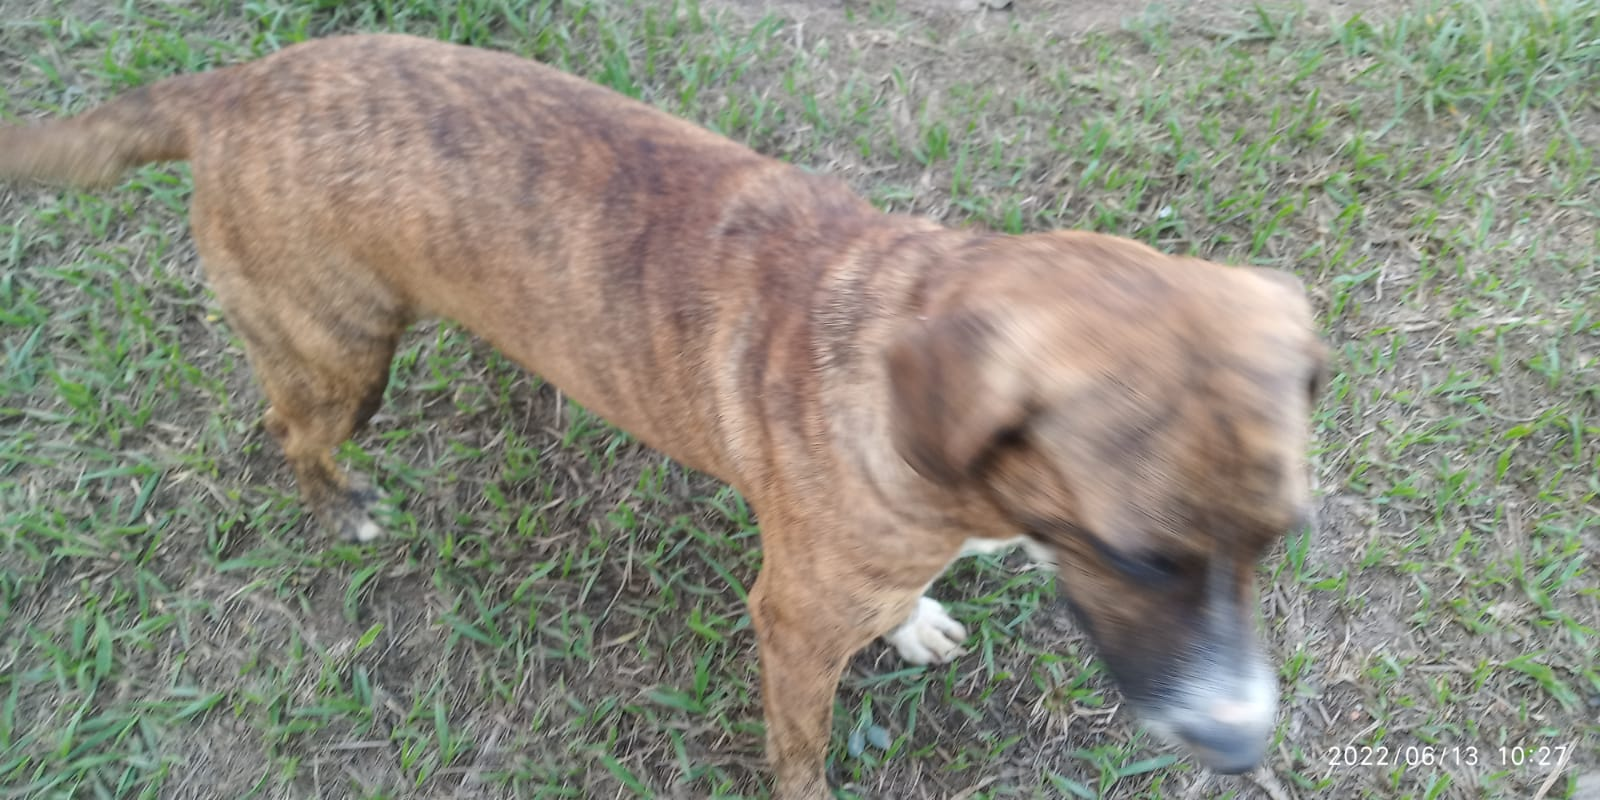

In [ ]:
filename = "/content/Dog_Cat/dataset_teste_local/A (5).jpeg"


img = keras.preprocessing.image.load_img(
    filename, target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)
from IPython.display import Image, display
display(Image(filename))

### Multiplas imagens

In [ ]:
numero_imagens = 100
confianca = 99 # se o modelo tiver 80% ou mais de certeza que a imagem é de um cão, então ela sera classificada como cão

cao = 0 # quantidade de imagens classificadas com cão 
gato = 0 # quantidade de imagens classificadas com gato

for i in range(numero_imagens):
  filename = '/content/Dog_Cat/dataset_teste_local/dogs/A (' + str(i+1) + ').jpg'
  #filename = '/content/Dog_Cat/dataset_teste/' + str(i+1) + '.jpg'

  img = keras.preprocessing.image.load_img(
     filename, target_size=image_size
  )
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis

  predictions = model.predict(img_array)
  score = predictions[0]

  
  if (100*score) >= confianca: # ser cão
     cao = cao +1
  else:
    if (100 * (1 - score)) >= confianca: # ser gato
      gato = gato +1

nao_sabe = numero_imagens - (cao + gato)
porcentagem_gato = (gato / numero_imagens) * 100
porcentagem_cao = (cao / numero_imagens) * 100
porcentagem_nao_sabe = (nao_sabe / numero_imagens) * 100
      
print("Das "+ str(numero_imagens) + " Analisada: " + str(cao) +" ("+ str(porcentagem_cao) +" %)"+ " são de cachorros e "
     +  str(gato) +" ("+ str(porcentagem_gato) +" %)" + " são de gatos." + " Com "
     + str(confianca) +"% ou mais de confiança.")
print("E "+ str( nao_sabe) +" ("+ str(porcentagem_nao_sabe) +" %)" + " tem menos de " + str(confianca) + "% de certeza se é gato ou cão.")

Das 100 Analisada: 77 (77.0 %) são de cachorros e 0 (0.0 %) são de gatos. Com 99% ou mais de confiança.
E 23 (23.0 %) tem menos de 99% de certeza se é gato ou cão.


### Predição para CSV

In [ ]:
# Cria um dataframe para as previsões do modelo
import pandas as pd

# Criando o DataFrame vazio
df_xception = pd.DataFrame([], columns=['Amostra', 'Precisao', 'Gatos', 'Cachorros', 'Incertos'])

In [ ]:
# Realizar as medições
numero_imagens = 100


Amostra = 1  #  1 para cães e 0 para gatos.
while (Amostra >= 0):

  if(Amostra == 1):
    nome = "cachorros"
  else:
    nome = "gatos"
  
  for confianca in range(50, 101): # Medir a confianca entre 50% e 100%
    print(nome +": Executando: " + str(confianca) + "% confiança.") 
    
    cao = 0 # quantidade de imagens classificadas com cão 
    gato = 0 # quantidade de imagens classificadas com gato

    for i in range(numero_imagens):
      filename = '/content/Dog_Cat/dts/cats/A (' + str(i+1) + ').jpg'
      #filename = '/content/Dog_Cat/dataset_teste/' + str(i+1) + '.jpg'

      img = keras.preprocessing.image.load_img(
        filename, target_size=image_size
      )
      img_array = keras.preprocessing.image.img_to_array(img)
      img_array = tf.expand_dims(img_array, 0)  # Create batch axis

      predictions = model.predict(img_array)
      score = predictions[0]

      
      if (100*score) >= confianca: # ser cão
        cao = cao +1
      else:
        if (100 * (1 - score)) >= confianca: # ser gato
          gato = gato +1

    nao_sabe = numero_imagens - (cao + gato)
    porcentagem_gato = (gato / numero_imagens) * 100
    porcentagem_cao = (cao / numero_imagens) * 100
    porcentagem_nao_sabe = (nao_sabe / numero_imagens) * 100
          
    # Adiciona o resultado na Tabela
    df_xception = df_xception.append({'Amostra' : nome , 'Precisao' : confianca, 'Gatos' : porcentagem_gato,
                                                             'Cachorros' : porcentagem_cao, 'Incertos' : porcentagem_nao_sabe} , ignore_index=True)
  Amostra = Amostra -1

In [ ]:
#Criando o CSV
Nome_arquivo = "450_epocs_dataset_balanceado_Xception.csv"
df_xception.to_csv(Nome_arquivo, index = False)

# Extras

In [ ]:
# Apagar diretorio com arquivos

import shutil
pasta = "/content/Dog_Cat/train"
shutil.rmtree(pasta, ignore_errors=True)

In [ ]:
# Apagar arquivos

import os

for i in range(100):
  os.remove('/content/Dog_Cat/dataset_teste_local/A (' + str(i+1) + ').jpg')


In [ ]:
for i in range(12500):
  caminho_origem =  "/content/Dog_Cat/dataset_treino/cat." + str(i) + ".jpg"
  caminho_destino = "/content/Dog_Cat/dataset_treino/cats/cat." + str(i) + ".jpg"
  shutil.move(caminho_origem, caminho_destino)

# Referencias

[1] Baixar dados do Keggle. [video] https://www.youtube.com/watch?v=57N1g8k2Hwc \
[2] Baixar dados do Keggle. [Site] https://www.kaggle.com/general/74235 \
[3] DataSet com as imagens de cães e gatos do keggle: https://www.kaggle.com/c/dogs-vs-cats/data \
[4] Pagina das reagras para poder baixar o dataset: https://www.kaggle.com/competitions/dogs-vs-cats/rules \

[5] Colab de referencia para a arquitetura Xception: https://colab.research.google.com/drive/1MrVHG5B0xJB83G4hz8fSfgBCn7PwHAoh?usp=sharing#scrollTo=PfojoMdo5s8H \

[6] Explicação da rede Xception: https://maelfabien-github-io.translate.goog/deeplearning/xception/?_x_tr_sl=en&_x_tr_tl=pt&_x_tr_hl=pt-BR&_x_tr_pto=sc


[7] Curva de aprendizado https://jobu.com.br/2021/07/15/tutorial-do-tensorflow-2/ \